In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~/workspace/tacotron/'))

import argparse
from hparams import hparams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
from tacotron.alignment_synthesizer import AlignmentSynthesizer
from tacotron.pml_synthesizer import Configuration, PMLSynthesizer
import tensorflow as tf

In [2]:
FIGSIZE = (10, 6)

In [3]:
training_data_dir = '/media/josh/Store/tacotron-data/gran-lj-training'
metadata_filename = os.path.join(training_data_dir, 'test.txt')

cfg = Configuration(16000, 86)
synth = PMLSynthesizer(cfg)
# synth.load(checkpoint_path, hparams, gta=gta, model_name=args.variant)

with open(metadata_filename, encoding='utf-8') as f:
    metadata = [line.strip().split('|') for line in f]
    hours = sum((int(x[2]) for x in metadata)) * hparams.frame_shift_ms / (3600 * 1000)
    print('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))
    
pml_features = [m[3] for m in metadata]
texts = [m[5] for m in metadata]
wav_files = [m[6] for m in metadata]

Loaded metadata for 150 examples (0.68 hours)


In [4]:
TARGET_INDEX = 26
texts[TARGET_INDEX]

'Also the Department requests the sum of one hundred thousand dollars to conduct a detailed feasibility study;'

In [3]:
def get_losses(checkpoint, key='model/stats/loss'):
    losses = []
    
    # This example supposes that the events file contains summaries with a
    # summary value tag 'loss'.  These could have been added by calling
    # `add_summary()`, passing the output of a scalar summary op created with
    # with: `tf.scalar_summary(['loss'], loss_tensor)`.
    summ_iter = tf.train.summary_iterator(checkpoint)

    # infinite loop
    while True:
        try:
            # get the next item
            element = next(summ_iter)
            # do something with element
            for v in element.summary.value:
                if v.tag == key:
                    losses.append(v.simple_value)
        except tf.errors.DataLossError:
            pass
        except StopIteration:
            # if StopIteration is raised, break from loop
            break
            
    return losses

In [4]:
tacotron_lj_pmlx_loss = []
tacotron_lj_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-lj-500k/events.out.tfevents.1551261505.air208', key='model/stats/loss_pml')
tacotron_lj_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-lj-500k/events.out.tfevents.1551471596.air208', key='model/stats/loss_pml')
tacotron_lj_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-lj-500k/events.out.tfevents.1551904223.air208', key='model/stats/loss_pml')
# tacotron_lj_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-lj-500k/events.out.tfevents.1551977987.air208')
# tacotron_lj_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-lj-500k/events.out.tfevents.1557985364.air208')
# tacotron_lj_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-lj-500k/events.out.tfevents.1557999848.air208')
tacotron_lj_pmlx_loss = np.array(tacotron_lj_pmlx_loss)
tacotron_lj_pmlx_loss.shape

(1322,)

In [5]:
locsens_pmlx_loss = []
locsens_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-locsens-lj-150k/events.out.tfevents.1557999848.air208', key='model/stats/loss_pml')
locsens_pmlx_loss += get_losses('/media/josh/Store/remote-logs/pmlx-locsens-lj-150k/events.out.tfevents.1558254576.air208', key='model/stats/loss_pml')
locsens_pmlx_loss = np.array(locsens_pmlx_loss)
locsens_pmlx_loss.shape

(1099,)

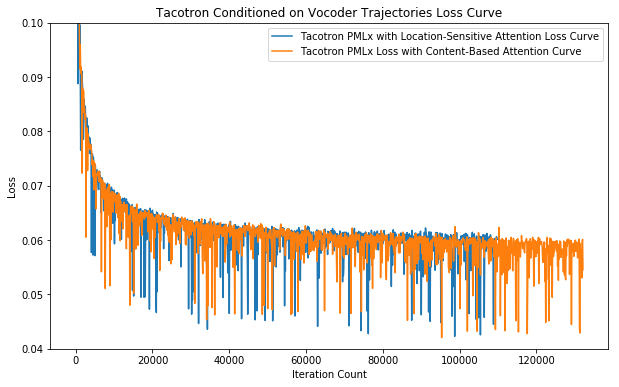

In [36]:
pmlx_iter_counts = np.arange(0, tacotron_lj_pmlx_loss.size) * 100
locsens_iter_counts = np.arange(0, locsens_pmlx_loss.size) * 100
plt.figure(figsize=FIGSIZE)
plt.plot(locsens_iter_counts, locsens_pmlx_loss)
plt.plot(pmlx_iter_counts, tacotron_lj_pmlx_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration Count')
plt.title('Tacotron Conditioned on Vocoder Trajectories Loss Curve')
plt.legend(['Tacotron PMLx with Location-Sensitive Attention Loss Curve', 'Tacotron PMLx Loss with Content-Based Attention Curve'])
plt.ylim(0.04, 0.10)
plt.show()

In [7]:
np.mean(locsens_pmlx_loss[200:]), np.mean(tacotron_lj_pmlx_loss[200:])

(0.059993978316281345, 0.05946106811962132)

In [5]:
def show_alignment(alignment, label, ax, cmap=cm.cool, cutoff=220, scale_factor=1, norm=False):
    # normalise the alignment to scale from 0 to 1
    if norm:
        alignment = alignment / np.max(alignment)
    
    # set the background of the axis to black
    ax.set_facecolor('xkcd:black')
    
    cool = cmap(np.arange(cmap.N))
    # Set alpha
    cool[:, -1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    cool = ListedColormap(cool)
    # generate the image
    im_obj = Image.fromarray(np.uint8(cool(alignment) * 255))
    height, width = alignment.shape
    im_obj = im_obj.resize((round(width * scale_factor), height))
    im_obj = np.array(im_obj)[:, :cutoff]
    
    im = ax.imshow(
        im_obj / 255,
        cmap=cmap,
        aspect='auto',
        origin='lower',
        interpolation='none')
    
    patch = mpatches.Patch(color=cool(0.8), label=label)
    
    xstep = 50
    outputs_per_step = 5
    frame_shift = 0.005
    plt.xticks(np.arange(0, 250, step=xstep),
               np.arange(0, 250 * frame_shift * outputs_per_step, step=frame_shift * outputs_per_step * xstep))
    plt.xlabel('Decoder Time (s)')
    plt.ylabel('Encoder Step (character index)')
    plt.tight_layout()
    
    return im, patch

In [6]:
# fixed_sentence = 'by offering life pensions at full pay for federal judges on all courts who are willing to retire at seventy.'
# fixed_sentence = 'Scientists at the CERN laboratory say they have discovered a new particle.'
fixed_sentence = texts[TARGET_INDEX]

# reset the graph before we do anything
tf.reset_default_graph()
synth = AlignmentSynthesizer()
synth.load('/media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000', hparams, model_name='tacotron_pml_x', locked_alignments=None)
pmlx_alignment = synth.synthesize(fixed_sentence)  # of shape (encoder_steps, decoder_steps)

# reset the graph after the first synthesise call
tf.reset_default_graph()
synth.load('/media/josh/Store/remote-logs/pmlx-locsens-lj-150k/model.ckpt-109000', hparams, model_name='tacotron_pml_x_locsens', locked_alignments=None)
locsens_alignment = synth.synthesize(fixed_sentence)

Constructing model: tacotron_pml_x
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  430
  decoder out (1 frame):   86
  postnet out:             256
  pml out:                 86
Loading checkpoint: /media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000
Constructing model: tacotron_pml_x_locsens
Initialized Tacotron model. Dimensions: 
  Train mode:              False
  GTA mode:                False
  Embedding:               256
  Prenet out:              128
  Encoder out:             256
  Attention out:           256
  Concat attn & out:       512
  Decoder cell out:        256
  Decoder out (5 frames):  430
  Decoder out (1 frame):   86
  Postnet out:             256
  PM

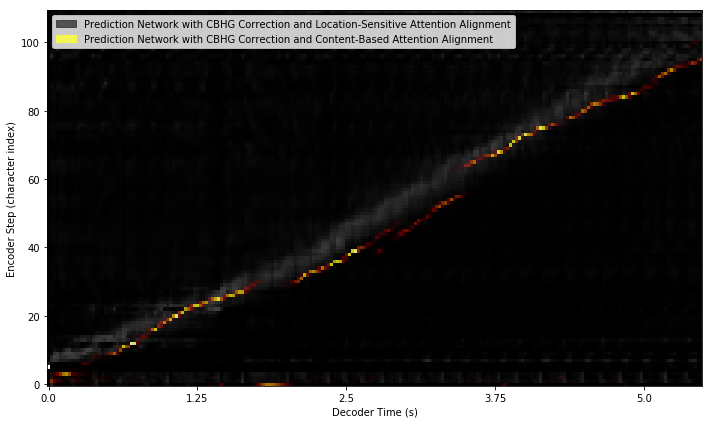

In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE)

im, taco_pml_patch = show_alignment(locsens_alignment * 3, 'Prediction Network with CBHG Correction and Location-Sensitive Attention Alignment', ax, cmap=cm.binary)
_, taco_patch = show_alignment(pmlx_alignment, 'Prediction Network with CBHG Correction and Content-Based Attention Alignment', ax, cmap=cm.hot)
ax.legend(handles=[taco_pml_patch, taco_patch], loc='upper left')
# fig.colorbar(im, ax=ax)

plt.savefig('./LocSensAttention/LocSensAlignment.png', dpi=600)
plt.show()

In [9]:
# reset the graph after the second synthesise call
tf.reset_default_graph()
synth.load('/media/josh/Store/remote-logs/post-locsens-lj-500k/model.ckpt-248000', hparams, model_name='tacotron_pml_locsens', locked_alignments=None)
postnet_alignment = synth.synthesize(fixed_sentence)

Constructing model: tacotron_pml_locsens
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  430
  decoder out (1 frame):   86
Loading checkpoint: /media/josh/Store/remote-logs/post-locsens-lj-500k/model.ckpt-248000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/post-locsens-lj-500k/model.ckpt-248000


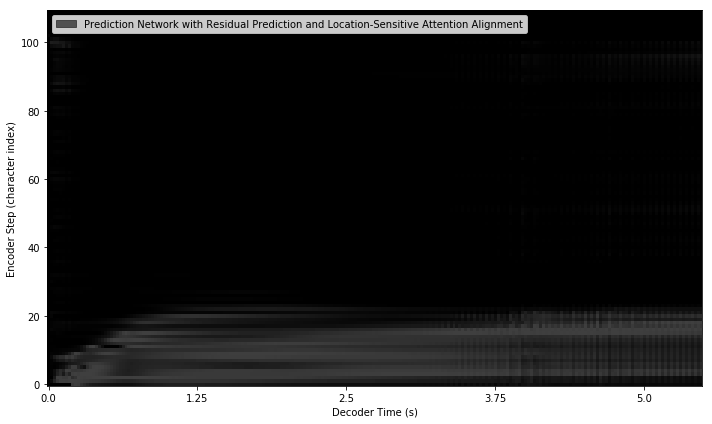

In [13]:
fig, ax = plt.subplots(figsize=FIGSIZE)

_, taco_pml_postnet_patch = show_alignment(postnet_alignment * 5, 'Prediction Network with Residual Prediction and Location-Sensitive Attention Alignment', ax, cmap=cm.binary)
# taco_patch = show_alignment(second_alignment, 'Tacotron Alignment', ax, cmap=cm.Wistia, scale_factor=12.5 / 5)
# taco_pmlx_patch = show_alignment(third_alignment, 'Tacotron PML Extended Alignment', ax, cmap=cm.Wistia)
ax.legend(handles=[taco_pml_postnet_patch], loc='upper left')

plt.savefig('./LocSensAttention/PostnetLocsensAlignmentScaled.png', dpi=600)
plt.show()

In [34]:
from tacotron.pml_synthesizer import Configuration, PMLSynthesizer
from lib import sigproc as sp
from util import audio

# reset the graph before we do anything
tf.reset_default_graph()
cfg = Configuration(16000, 86)
pml_synth = PMLSynthesizer(cfg)
pml_synth.load('/media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000', hparams, model_name='tacotron_pml_x')
wav_outputs = pml_synth.synthesize([fixed_sentence], to_wav=True)

wav = wav_outputs[0]
wav = wav[:audio.find_endpoint(wav)]
sp.wavwrite('./LocSensAttention/pmlx_output.wav', wav, 16000, norm_max_ifneeded=True)

# reset the graph before we do anything
tf.reset_default_graph()
pml_synth.load('/media/josh/Store/remote-logs/pmlx-locsens-lj-150k/model.ckpt-109000', hparams, model_name='tacotron_pml_x_locsens')
wav_outputs = pml_synth.synthesize([fixed_sentence], to_wav=True)

wav = wav_outputs[0]
wav = wav[:audio.find_endpoint(wav)]
sp.wavwrite('./LocSensAttention/locsens_output.wav', wav, 16000, norm_max_ifneeded=True)

Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  430
  decoder out (1 frame):   86
  postnet out:             256
  pml out:                 86
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/pmlx-locsens-lj-150k/model.ckpt-109000


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


In [ ]:
wav = wav_outputs[0]
wav = wav[:audio.find_endpoint(wav)]
sp.wavwrite('./LocSensAttention/locsens_output.wav', wav, 16000, norm_max_ifneeded=True)